In [28]:
import numpy as np
import random
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

from pathlib import Path
import os
import re

#need to pip install opencv-python
import cv2
from skimage.color import rgb2gray #convert RGB to gray color
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [29]:
#Get the total classes we have
class_names = [class_name for class_name in os.listdir("/Users/stuartfinley/Downloads/Images_augmentation") if not class_name.startswith(".")]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)
print(f"We have in total {nb_classes} different classes."+
      f"\nAnd they are:\n {', '.join(classes for classes in class_names)}.")

We have in total 12 different classes.
And they are:
 tshirt, sunglasses, watches, speaker, chair, shorts, phone, earbuds, hat, ImageFolder2, shoes, bottle.


In [30]:
#Load the data from each folder
def load_image_from_folder(root_dir, max_img_perclass = 4000):

    images = []
    labels = []
    IMAGE_SIZE = (150, 150)

    for folder in os.listdir(root_dir):
        #Because there are some configure file also sitting there  
        if folder.startswith("."):
            continue
        label = class_names_label[folder]
        total_img_perclass = 0
        for root, dirs, files in os.walk(os.path.join(root_dir, folder), topdown = True):
            # Get the path name of the image
            for file in files:
                img_path = os.path.join(root,file)
                #open and resize the image, read in as 3d array
                '''
                The reason we add try except is because some iamges just cannot be read in to cv2
                for example this one: ./updated images/watches/712+lS1mk-L._AC_UL320_.jpg
                I dont know why.

                Also, there are some corrupted images like this one: ./updated images/watches/814cT4PAxeL._AC_UL320_.jpg
                However, cv2 wont allow us to capture this images. We will still keep them in our image pool,
                because they dont really cause any issue.

                If you do want learn more read https://medium.com/joelthchao/programmatically-detect-corrupted-image-8c1b2006c3d3
                and
                https://scikit-image.org/
                '''
                try:
                    image = cv2.imread(img_path)
                    #cv2.cvtColor() method is used to convert an image from one color space to another.
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
                    #is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
                    #The aspect ratio is preserved when we specify the scaling factor.
                    image = cv2.resize(image, IMAGE_SIZE)
                except:
                    continue
                
                total_img_perclass += 1
                if total_img_perclass > max_img_perclass:
                    break
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
    # The original dtypes of image is uint8 (Unsigned integer type, from 0 to 18_446_744_073_709_551_615)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return ((images, labels))

In [31]:
import warnings
warnings.filterwarnings("ignore")
images, labels = load_image_from_folder('/Users/stuartfinley/Downloads/Images_augmentation',max_img_perclass = 800)

#Shuffle arrays or sparse matrices in a consistent way.
#This is a convenience alias to resample(*arrays, replace=False) to do random permutations of the collections.
#otherwise imaages are grouped all together based on their classes
images_r, labels_r = shuffle(images, labels, random_state=25)

Corrupt JPEG data: 1955 extraneous bytes before marker 0xc4
Corrupt JPEG data: 757 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 250 extraneous bytes before marker 0xc4
Corrupt JPEG data: 3186 extraneous bytes before marker 0xc4
Corrupt JPEG data: 4436 extraneous bytes before marker 0xc4
Corrupt JPEG data: 2472 extraneous bytes before marker 0xc4
Corrupt JPEG data: 897 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 1003 extraneous bytes before marker 0xc4
Corrupt JPEG data: 1312 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code


How many images in each class?


,,,,,,,,,,,
Class,bottle,chair,earbuds,hat,phone,shoes,shorts,speaker,sunglasses,tshirt,watches
Total Amount,800,800,800,800,800,800,800,800,800,800,800


Each image size is: (150, 150).


IndexError: index 0 is out of bounds for axis 0 with size 0

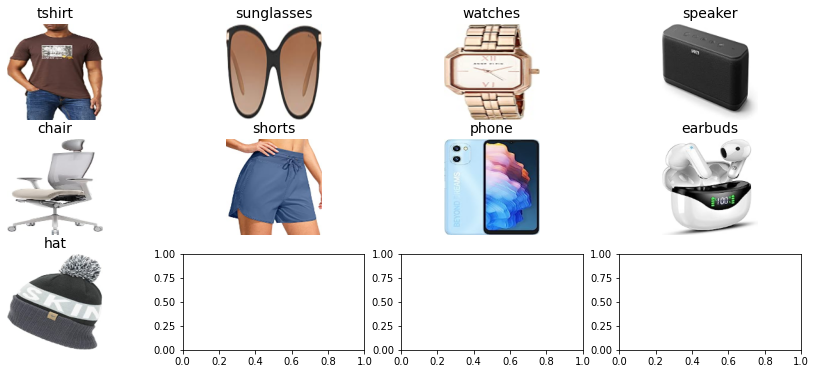

In [32]:
'''
How many images in each class?
'''

print("How many images in each class?")
class_name, count_name = np.array(np.unique(np.array(class_names)[labels_r], return_counts=True))
total_images = pd.DataFrame((class_name, count_name), 
             index = ["Class", "Total Amount"], columns = ['']*len(class_name))
display(total_images)

print(f"Each image size is: {IMAGE_SIZE}.")

#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    x = images_r[labels_r == i][0].astype('uint8')
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

IndexError: index 0 is out of bounds for axis 0 with size 0

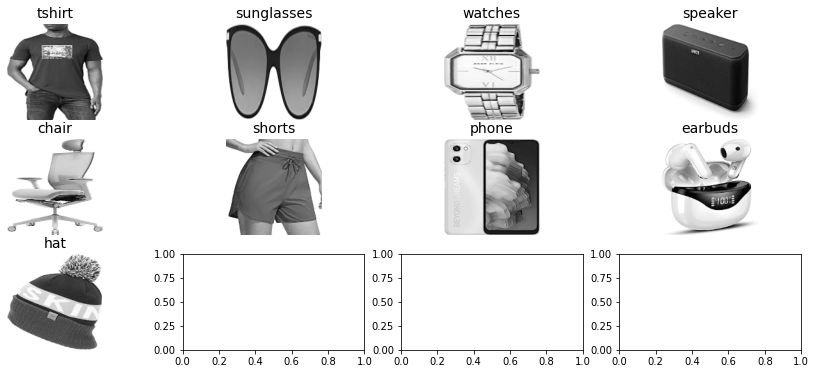

In [33]:
#1: remove colours
import warnings
warnings.filterwarnings("ignore")
images_r_g = np.zeros(images_r.shape[0:3])
for i in range(images_r.shape[0]):
    images_r_g[i] = rgb2gray(images_r[i])
    
#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    #x = images_r[labels_r == i][0].astype('uint8')
    x = images_r_g[labels_r == i][0]
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

In [34]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

#reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

#look at the shaoe of training and testing
X_train_norm.shape, X_test_norm.shape

((7040, 22500), (1760, 22500))

In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as tk
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import sequence
from keras.models import Model

%matplotlib inline

In [36]:
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

In [37]:
from keras.layers import Dropout
from keras.layers import Dense

In [38]:

print(X_train.shape)
print(np.max(X_train))

# the y_train the group label for the training data
print(y_train.shape)
print(np.unique(y_train))

(7040, 150, 150)
255.0
(7040,)
[ 0  1  2  3  4  5  6  7  8 10 11]


In [39]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [41]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np


# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

#reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

#look at the shaoe of training and testing
X_train_norm.shape, X_test_norm.shape

# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape input data
X_train = X_train.reshape(-1, 150, 150, 1)
X_test = X_test.reshape(-1, 150, 150, 1)

# define a function that creates the Keras model
def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(12, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# create the Keras classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=32, verbose=2)

# define the hyperparameter search space
param_grid_cnn = {
    'learning_rate': [0.001, 0.01, 0.1]
}

# set up early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

# perform random search cross-validation
cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid_cnn, n_iter=15, cv=3, verbose=2, n_jobs=6)
cv.fit(X_train, y_train, callbacks=[early_stopping], validation_split=0.2)


# print the best hyperparameters and test accuracy
print("Best hyperparameters: ", cv.best_params_)
print("Test accuracy: %.3f" % cv.score(X_test, y_test))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/15
Epoch 1/15
Epoch 1/15
Epoch 1/15
Epoch 1/15
Epoch 1/15
118/118 - 218s - loss: 52.6267 - accuracy: 0.0945 - val_loss: 2.4062 - val_accuracy: 0.0735 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 218s - loss: 3.8431 - accuracy: 0.4115 - val_loss: 1.4164 - val_accuracy: 0.5708 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 218s - loss: 29.0295 - accuracy: 0.0847 - val_loss: 2.4086 - val_accuracy: 0.0927 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 218s - loss: 3.3945 - accuracy: 0.3895 - val_loss: 1.6142 - val_accuracy: 0.4846 - 218s/epoch - 2s/step
Epoch 2/15
118/118 - 219s - loss: 3.5189 - accuracy: 0.4081 - val_loss: 1.3301 - val_accuracy: 0.5921 - 219s/epoch - 2s/step
Epoch 2/15
118/118 - 219s - loss: 50.8510 - accuracy: 0.0898 - val_loss: 2.4046 - val_accuracy: 0.0863 - 219s/epoch - 2s/step
Epoch 2/15
118/118 - 213s - loss: 2.4061 - accuracy: 0.0868 - val_loss: 2.4065 - val_accuracy: 0.0937 - 213s/epoch - 2s/step
Epoch 3/

In [42]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

# Reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape input data
X_train = X_train.reshape(-1, 150, 150, 1)
X_test = X_test.reshape(-1, 150, 150, 1)

# Define a function that creates the Keras model
def create_model(learning_rate=0.01, activation='relu', batch_size=32, epochs=15):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation, input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation=activation))
    model.add(Dropout(rate=0.4))
    model.add(Dense(12, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the Keras classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=2)

# Define the hyperparameter search space
param_grid_cnn = {
    'learning_rate': [0.0001, 0.001],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'batch_size': [16, 32, 64],
    'epochs': [20]
}

# Set up early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

# Perform random search cross-validation
cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid_cnn, n_iter=15, cv=3, verbose=2, n_jobs=6)
cv.fit(X_train, y_train, callbacks=[early_stopping], validation_split=0.2)


# print the best hyperparameters and test accuracy
print("Best hyperparameters: ", cv.best_params_)
print("Test accuracy: %.3f" % cv.score(X_test, y_test))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
59/59 - 218s - loss: 3.9646 - accuracy: 0.0945 - val_loss: 2.4848 - val_accuracy: 0.0735 - 218s/epoch - 4s/step
Epoch 2/20
118/118 - 220s - loss: 3.4865 - accuracy: 0.0945 - val_loss: 2.3867 - val_accuracy: 0.1565 - 220s/epoch - 2s/step
Epoch 2/20
59/59 - 223s - loss: 3.7731 - accuracy: 0.0868 - val_loss: 2.4047 - val_accuracy: 0.1086 - 223s/epoch - 4s/step
Epoch 2/20
59/59 - 224s - loss: 3.4723 - accuracy: 0.1145 - val_loss: 2.2862 - val_accuracy: 0.1544 - 224s/epoch - 4s/step
Epoch 2/20
118/118 - 225s - loss: 3.1914 - accuracy: 0.1188 - val_loss: 2.2625 - val_accuracy: 0.2034 - 225s/epoch - 2s/step
Epoch 2/20
118/118 - 226s - loss: 3.5668 - accuracy: 0.0890 - val_loss: 2.4265 - val_accuracy: 0.1086 - 226s/epoch - 2s/step
Epoch 2/20
59/59 - 220s - loss: 2.9130 - accuracy: 0.0932 - val_loss: 2.4714 - val_accuracy: 0.0735 - 220s/epoch - 4s/step
Epoch 3/20
118/11